# Quick Tutorial on Python Interaction with the HGCAL INT2R database
## Ali Al Kadhim - FSU
## May 2023

In [1]:
import cx_Oracle
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import argparse
import os
import IPython
from IPython.display import Image, display
import time
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
# USE PYTHON3  !

os.environ['PASCAL']='/home'

In [42]:
print(os.environ['PASCAL'])
PASCAL=os.environ['PASCAL']
OUTPUT_DIR=os.path.join(PASCAL,'outputs')
QUERY_DIR=os.path.join(PASCAL,'queries')
LOG_DIR=os.path.join(PASCAL,'logs')
IMAGE_DIR=os.path.join(PASCAL,'images')

/home


Make sure you've run `bash tunnel.sh username` before starting this or in the same terminal that is running this notebook

- Show image(s)

- Each query is saved in a .sql file, and the function just opens and grabs these
- Query History/log. Maybe everytime you run "execute_query"
- Option to Save query if you like it, or put your own query in the queries directory as a .sql


In [3]:
print(time.time)

<built-in function time>


In [4]:
############################# Some helper functions ##############
# def printException(exception):
#       error, = exception.args
#   printf("Error code = %s\n",error.code)
#   printf("Error message = %s\n",error.message)

def printf(format,*args):
      sys.stdout.write(format % args)

def show_jupyter_image(image_filename, width=1300, height=300):
    """Show a saved image directly in jupyter. Make sure image_filename is in your IQN_BASE !"""
    display(Image(os.path.join(os.environ['PASCAL'], 'images', image_filename), width=width, height=height))

def makeDictFactory(cursor):
    columnNames = [d[0] for d in cursor.description]
    def createRow(*args):
        return dict(zip(columnNames, args))
    return createRow



############################ Some decorators ############################
def SourcePASCAL(func):
    def _func(*args):
        import os
        from common.utility.source import source

        env = {}
        env.update(os.environ)
        env.update(source(os.environ["PASCAL"]))
        func(*args, env=env)

    return _func

def debug(func):
    """Print the function signature and return value"""
    import functools

    @functools.wraps(func)
    def wrapper_debug(*args, **kwargs):
        args_repr = [repr(a) for a in args]
        kwargs_repr = [f"{k}={v!r}" for k, v in kwargs.items()]
        signature = ", ".join(args_repr + kwargs_repr)
        print(f"Calling {func.__name__}({signature})")
        values = func(*args, **kwargs)
        print(f"{func.__name__!r} returned {values!r}")
        return values

    return wrapper_debug

def make_interactive(func):
    """make the plot interactive"""
    import functools

    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        plt.ion()
        output = func(*args, **kwargs)
        plt.ioff()
        return output

    return wrapper

def timer(func):
    """Print the runtime of the decorated function"""
    import functools
    import time
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        start_time = time.perf_counter()    # 1
        value = func(*args, **kwargs)
        end_time = time.perf_counter()      # 2
        run_time = end_time - start_time    # 3
        print(f"\nFINISHED {func.__name__!r} in {run_time:.4f} SECS")
        return value
    return wrapper_timer

# from IPython.core.magic import register_cell_magic

# @register_cell_magic
def write_and_run(line, cell):
    """write the current cell to a file (or append it with -a argument) as well as execute it
    use with %%write_and_run at the top of a given cell"""
    argz = line.split()
    file = argz[-1]
    mode = "w"
    if len(argz) == 2 and argz[0] == "-a":
        mode = "a"
    with open(file, mode) as f:
        f.write(cell)
    # get_ipython().run_cell(cell)
############################  ############################


### Screenshot of dbolader diagram

### Screenshot of XML template -> SQL Developer view

In [5]:
# show_jupyter_image(image_filename)

## Define Connection Configurations


The database is  a Oracle Database, with access permitted at port 10131. For Int2R, The service name, username, and passwork are 'int2r_lb.cern.ch', 'HGCAL_Reader_2016' and 'CMS_HGC_PRTTYPE_HGCAL_READER', respectively.

In [6]:
HOST='localhost'
PORT = '10131'
SERVICE_NAME='int2r_lb.cern.ch'
PASS=r'HGCAL_Reader_2016'
USER=r'CMS_HGC_PRTTYPE_HGCAL_READER'

make TNS connection

In [7]:
DSN_TNS = cx_Oracle.makedsn(HOST, PORT, service_name=SERVICE_NAME)

In [8]:
def output_type_handler(cursor, name, default_type, size, precision, scale):
    if default_type == cx_Oracle.DB_TYPE_VARCHAR:
        return cursor.var(default_type, size, arraysize=cursor.arraysize,
                          encoding_errors="replace")

# cursor.outputtypehandler = output_type_handler

Create the connection only once for faster eqxecution

In [9]:
try:
    conn = cx_Oracle.connect(user=USER, password=PASS, dsn=DSN_TNS, 
                       # encoding="UTF-8"
                       ) 
    print("\nGreat! You've successfully Connected to the Database\n")
except Exception:
    print("\nUnfortunately, you have not connected to the database. Do you have access permission from Umesh or Haffeez?\n")


Great! You've successfully Connected to the Database



In [10]:
def makeDictFactory(cursor):
    columnNames = [d[0] for d in cursor.description]
    def createRow(*args):
        return dict(zip(columnNames, args))
    return createRow

# Quick Tutorial on SQL queries in HGCAL INT2R

SQL for data-retrieval in a nutshell: `

Look at the Documentation [here](https://readthedocs.web.cern.ch/display/HGCLogic/HGCAL+DB+tables+-+documentation+for+assembly) for explanation of the schemas, tables and attributes. Since this is made from SQC-related tables perspective, we will be using the tables in the `CMS_HGC_CORE_COND` schema.


You should think of the `CMS_HGC_CORE_COND.COND_DATA_SETS` table as the master table that has a record of everything that was uploaded, and the `CONDITION_DATA_SET_ID` as the successful upload ID that relates schemas and tables.

### Part 1: Sample Queries to Get Started

`select * from CMS_HGC_CORE_COND.KINDS_OF_CONDITIONS;` translates to "show all columns and rows from the `KINDS_OF_CONDITIONS` table in the `CMS_HGC_CORE_COND` account

In [11]:
QUERY2="select * from CMS_HGC_CORE_COND.KINDS_OF_CONDITIONS"

## We will Ue [cx_Oracle](https://cx-oracle.readthedocs.io/) for the interface with the DB, all the dependencies and configurations have been configured in the Pascal docker image

## We will execute any SQL query (that permitted by [cx_Oracle](https://cx-oracle.readthedocs.io/) ), and return output as pandas DataFrame


In [13]:
@timer
def execute_query(QUERY, maxrows ='all', outformat='DF', saveformat=None, outstring=None):
    """
    
    Args:
    outformat: the format of the result. DF = pandas.DataFrame(),
    """
    # conn = None
    try:
    # if you want a new connection and close it at the end, uncomment below
      conn = cx_Oracle.connect(user=USER, password=PASS, dsn=DSN_TNS, 
                               # encoding="UTF-8"
                               ) 


      cursor = conn.cursor()

    except Exception as err:
      print('Connection error')
      print(err)
    finally:
      if conn:
            if maxrows=='all':
            # execute
                cursor.execute(QUERY)
            # rows = cursor.execute(QUERY2)
            # cursor.execute(QUERY_TIME_3)
            # conn.commit()
            else:
                cursor.execute(QUERY,offset=0, maxnumrows=maxrows)
            
            # try:
              # rows=cursor.fetall()
            # except Exception as err:
              # print(err)
            columnNames = [d[0] for d in cursor.description]
            print('\nCOLUMN NAMES:\n', columnNames)
            # for row in rows:
                  # print(list(row))
            #return result as a dictionary
            result = [dict(zip(columnNames, row)) for row in cursor.fetchall()]
            # result=None
            cursor.close()
            conn.close()
    
    if outformat=='DF':
        df =pd.DataFrame(result)
    
    
    
    if saveformat=='CSV':
        df.to_csv(f'{outstring}.csv')
    # print(df.head())
    return df

See all attempts to upload and their success/failure status and their logs. Replace "Ali" with the name of the user who aploaded something, and you should see it, whether it was uploaded successfully and a log file associated with it!

```
select * from CMS_HGC_CORE_MANAGEMNT.CONDITIONS_DATA_AUDITLOG where RECORD_LASTUPDATE_USER LIKE 'Ali%';
```


In [14]:
def auditlog(username):
    AUDITLOG_ALI="select * from CMS_HGC_CORE_MANAGEMNT.CONDITIONS_DATA_AUDITLOG where RECORD_LASTUPDATE_USER LIKE '{}%'".format(username)
    AUDITLOG_ALI_DF=execute_query(AUDITLOG_ALI)
    # print(AUDITLOG_ALI_DF)
    return AUDITLOG_ALI_DF

`username=''` displays all usernames. Put your name to see info on what you uploaded, like `Ali`

In [15]:
widgets.interact(auditlog, username='')

interactive(children=(Text(value='', description='username'), Output()), _dom_classes=('widget-interact',))

<function __main__.auditlog(username)>

## Part 2: Predifined queries from file in Pascal

There are a bunch of predefined query templates that we think are useful for people.

## Queries List

| Filename | description | jupyter usage example | terminal usage example |
-------| --- | ---- | ---- |
|`'CV_FULL.sql'` | Plot all bias voltage vs capactivance (CV) for every cell at every voltage step | `get_query_from_file('CV_FULL.sql')` | --- |
-------| --- | ---- | --- | 

In [20]:
! ls

Dockerfile			pascal_run_command.sh	   PascalUtils.py
MAIN_Pascal_Tutorial1_V1.ipynb	Pascal_Tutorial2_V1.ipynb  utils


In [22]:
! ls ../queries

CV_FULL.sql


In [23]:
def get_query_from_file(query_file):
    query_file_path = os.path.join(QUERY_DIR,query_file)
    query_f = open(query_file_path)
    QUERY = query_f.read()
    # print(QUERY)
    query_f.close()

    return QUERY

In [24]:
CV_QUERY_REP = get_query_from_file('CV_FULL.sql')
print(CV_QUERY_REP)

SELECT SNSRPRT.SERIAL_NUMBER SCRATCHPAD_ID, 
SNSRPRT.NAME_LABEL SENSOR_ID,
SNSRCEL.SERIAL_NUMBER SCRATCHPAD_ID_CELL, 
HGCSNSRCV.VOLTS, 
HGCSNSRCV.CPCTNCE_PFRD,  
HGCSNSRCV.ERR_CPCTNC_PFRD, 
HGCSNSRCV.TOT_CURNT_NANOAMP, 
HGCSNSRCV.ACTUAL_VOLTS, 
HGCSNSRCV.ORG_CPCTNC_PFRD, 
HGCSNSRCV.TEMP_DEGC, 
HGCSNSRCV.HUMIDITY_PRCNT, 
HGCSNSRCV.IMP_OHM, 
HGCSNSRCV.PHS_RAD, 
HGCSNSRCV.TIME_SECS, 
HGCSNSRCV.CELL_NR  
FROM CMS_HGC_CORE_CONSTRUCT.KINDS_OF_PARTS SNSRKOP
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PARTS SNSRPRT
ON SNSRKOP.KIND_OF_PART_ID = SNSRPRT.KIND_OF_PART_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PHYSICAL_PARTS_TREE SNSRPHPRT
ON SNSRPRT.PART_ID = SNSRPHPRT.PART_PARENT_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PARTS SNSRCEL
ON SNSRPHPRT.PART_ID = SNSRCEL.PART_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.KINDS_OF_PARTS CELLKOP
ON SNSRCEL.KIND_OF_PART_ID = CELLKOP.KIND_OF_PART_ID
INNER JOIN CMS_HGC_CORE_COND.COND_DATA_SETS CONDS
ON SNSRCEL.PART_ID = CONDS.PART_ID
INNER JOIN CMS_HGC_CORE_COND.KINDS_OF_CONDITIONS SNS

### Plot and Interact

In [26]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    # colors = mcolors.TABLEAU_COLORS
    # dl = list(colors.items())
    # print(dl[0][1])
    return plt.cm.get_cmap(name, n)

In [45]:
def plot_CV(sensor_id, saveplot):
    # convert SOME_SENSOR_SERIAL_NUMBER in the file to the sensor ID
    cmd = """sed -i "s/'SOME_SENSOR_SERIAL_NUMBER'/'%s'/g" /home/queries/CV_FULL.sql""" % str(sensor_id)
    os.system(cmd)
    CV_QUERY_REP=get_query_from_file(query_file='CV_FULL.sql')
    # remove the last ";" from the sql command in the file to make it executable here
    length=len(CV_QUERY_REP)
    # print(length-1)
    # print(CV_QUERY_REP[:-1])
    CV_QUERY_REP=CV_QUERY_REP[:length-3]
    # print(CV_QUERY_REP[:length-3])
    QUERY_OUT = execute_query(CV_QUERY_REP)
    print(QUERY_OUT.head())
    
    # now convert back to the original SOME_SENSOR_SERIAL_NUMBER
    cmd = """sed -i "s/'%s'/'SOME_SENSOR_SERIAL_NUMBER'/g" /home/queries/CV_FULL.sql""" % str(sensor_id)
    os.system(cmd)
    
    start_time = time.perf_counter()   
    #measure the time for plotting
    max_cells=QUERY_OUT['CELL_NR'].max()
    # serial_number='100383'#aka SCRATCHPAD_ID
    serial_number=sensor_id
    fig,ax=plt.subplots(figsize=(25/3,35/3))
    # colors = mcolors.TABLEAU_COLORS
    # color_list = list(colors.items())
    # color_index = 0
    # cmap = get_cmap(QUERY_OUT.shape[1])
    cmap = get_cmap(255)

    # index = (index + 1) % len(my_list)
    for ind, cell_nr in enumerate(range(1,max_cells)):
        # keep looping back and forth in the colors list
        # color_index = (color_index + 1) % len(colors)
        # color = colors[color_index]
        # print('color index = ', color_index)
        plt.plot(QUERY_OUT['TOT_CURNT_NANOAMP'][QUERY_OUT['CELL_NR']==cell_nr], 
                 QUERY_OUT['ACTUAL_VOLTS'][QUERY_OUT['CELL_NR']==cell_nr], 
                 label = f'cell {cell_nr}',
                alpha=0.4,
                 # color = color_list[color_index][1],
                 # Randomly pick out a color from the cmap
                 color = cmap(ind),
                 linewidth=1.0
                 
                 
                )
        plt.ylabel('Actual Voltage (V)'); plt.xlabel('Total Current (NanoAmp)')
        plt.legend(ncol=5, fontsize=3)
    plt.grid()
    fig.suptitle(serial_number)
    plt.show()
    end_time = time.perf_counter()    
    run_time = end_time - start_time   
    print(f"Finished all plotting in {run_time:.4f} secs")
    if saveplot != 'False':
        imagename= '%s.pdf' % str(saveplot)
        print('\nOkay, saveing image to %s\n', os.path.join(IMAGE_DIR, imagename))
        plt.savefig(os.path.join(IMAGE_DIR, imagename))

In [44]:
! ls ../images

False.pdf  test.pdf


In [46]:
interact(plot_CV, sensor_id='100113', saveplot='False')

interactive(children=(Text(value='100113', description='sensor_id'), Text(value='False', description='saveplot…

<function __main__.plot_CV(sensor_id, saveplot)>

In [ ]:
QUERY2_DF = execute_query(QUERY2)
QUERY2_DF.head()

In [47]:
df = execute_query("""SELECT * FROM CMS_HGC_CORE_COND.HGC_CERN_SENSOR_IV where SERIAL_NUMBER='100113""")
df.head()

In [185]:
def show_IV_summary(sensor_ID):
    #just print the dataframe from the execute_query(<IV SUMMARY DF for Sensor_ID>)
    pass
    
def show_CV_summary(sensor_ID):
    #just print the dataframe from the execute_query(<IV SUMMARY DF for Sensor_ID>)
    pass

You can interact with this like any dataframe.

Now let's save the result of the query as a csv file

In [17]:
execute_query(QUERY2, 
              maxrows ='all', 
              outformat='DF', 
              saveformat='CSV', 
              outstring='Simple_KINDS_OF_CONDITIONS_Query')


COLUMN NAMES:
 ['KIND_OF_CONDITION_ID', 'IS_RECORD_DELETED', 'NAME', 'EXTENSION_TABLE_NAME', 'RECORD_INSERTION_TIME', 'RECORD_INSERTION_USER', 'RECORD_LASTUPDATE_TIME', 'RECORD_LASTUPDATE_USER', 'COMMENT_DESCRIPTION', 'CATEGORY_NAME']


,KIND_OF_CONDITION_ID,IS_RECORD_DELETED,NAME,EXTENSION_TABLE_NAME,RECORD_INSERTION_TIME,RECORD_INSERTION_USER,RECORD_LASTUPDATE_TIME,RECORD_LASTUPDATE_USER,COMMENT_DESCRIPTION,CATEGORY_NAME
0,2640,F,HGC Sensor Manufacturer IV Test,HGC_SENSOR_IV,2018-02-17 07:07:52,Umesh,2020-03-07 10:00:28,CMS_HGC_CORE_COND,HGC Sensor IV Test,MEASUREMENT
1,1100,F,Hamamatsu-S10938-4956 Sensor IV Test,TEST_SENSOR_IV,2017-09-14 06:44:30,Umesh,2020-03-07 10:11:03,CMS_HGC_CORE_COND,Hamamatsu-S10938-4956 Sensor IV Test,MEASUREMENT
2,1120,F,Hamamatsu-S10938-4956 Sensor CV Test,TEST_SENSOR_CV,2017-09-14 06:44:34,Umesh,2020-03-07 10:11:03,CMS_HGC_CORE_COND,Hamamatsu-S10938-4956 Sensor CV Test,MEASUREMENT
3,1140,F,Hamamatsu-S10938-4956 Sensor Test Conds,TEST_SENSOR_CONDITIONS,2017-09-14 06:44:37,Umesh,2020-03-07 10:11:03,CMS_HGC_CORE_COND,Hamamatsu-S10938-4956 Sensor Test Conditions,MEASUREMENT
4,18640,F,HGC Sensor Flatness Data,FLATNS_SENSOR_DATA,2022-10-10 12:18:42,Umesh,NaT,None,HGC Sensor Flatness Data,None
...,...,...,...,...,...,...,...,...,...,...
82,17080,F,SiPM HGCROC RAM Retention Time,HGCROC_RAM_RETENTION,2022-06-25 04:39:05,Umesh,NaT,None,SiPM HGCROC RAM Retention Time,None
83,17100,F,HD HGCROC DACB Conveyor Test,HGCROC_DACB_CONVEYOR_TEST,2022-06-25 05:11:06,Umesh,2022-06-25 05:16:37,CMS_HGC_CORE_COND,HD HGCROC_DACB_Conveyor_TEST,None
84,17120,F,LD HGCROC DACB Conveyor Test,HGCROC_DACB_CONVEYOR_TEST,2022-06-25 05:11:06,Umesh,2022-06-29 00:48:51,CMS_HGC_CORE_COND,LD HGCROC_DACB_Conveyor_TEST,None
85,17140,F,SiPM HGCROC DACB Conveyor Test,HGCROC_DACB_CONVEYOR_TEST,2022-06-25 05:11:07,Umesh,2022-06-29 00:48:55,CMS_HGC_CORE_COND,SiPM HGCROC_DACB_Conveyor_TEST,None


This results in a file called `Simple_KINDS_OF_CONDITIONS_Query.csv` in your working directory.

See all attempts to upload and their success/failure status and their logs. Replace "Ali" with the name of the user who aploaded something, and you should see it, whether it was uploaded successfully and a log file associated with it!

```
select * from CMS_HGC_CORE_MANAGEMNT.CONDITIONS_DATA_AUDITLOG where RECORD_LASTUPDATE_USER LIKE 'Ali%';
```

In [62]:
AUDITLOG_ALI="select * from CMS_HGC_CORE_MANAGEMNT.CONDITIONS_DATA_AUDITLOG where RECORD_LASTUPDATE_USER LIKE 'Ali%'"
AUDITLOG_ALI_DF=execute_query(AUDITLOG_ALI)
AUDITLOG_ALI_DF

COLUMN NAMES:
 ['RECORD_ID', 'RECORD_INSERTION_TIME', 'RECORD_INSERTION_USER', 'RECORD_LASTUPDATE_TIME', 'RECORD_LASTUPDATE_USER', 'COMMENT_DESCRIPTION', 'ARCHVE_FILE_NAME', 'DATA_FILE_NAME', 'DATA_FILE_CHECKSUM', 'UPLOAD_STATUS', 'UPLOAD_HOSTNAME', 'UPLOAD_SOFTWARE', 'UPLOAD_TIME_SECONDS', 'UPLOAD_LOG_TRACE', 'CREATE_TIMESTAMP', 'CREATED_BY_USER', 'VERSION', 'SUBVERSION', 'KIND_OF_CONDITION_NAME', 'EXTENSION_TABLE_NAME', 'SUBDETECTOR_NAME', 'RUN_TYPE', 'RUN_NUMBER', 'TAG_NAME', 'INTERVAL_OF_VALIDITY_BEGIN', 'INTERVAL_OF_VALIDITY_END', 'DATASET_COUNT', 'DATASET_RECORD_COUNT', 'DATA_RELATED_TO_LIST']


,RECORD_ID,RECORD_INSERTION_TIME,RECORD_INSERTION_USER,RECORD_LASTUPDATE_TIME,RECORD_LASTUPDATE_USER,COMMENT_DESCRIPTION,ARCHVE_FILE_NAME,DATA_FILE_NAME,DATA_FILE_CHECKSUM,UPLOAD_STATUS,...,EXTENSION_TABLE_NAME,SUBDETECTOR_NAME,RUN_TYPE,RUN_NUMBER,TAG_NAME,INTERVAL_OF_VALIDITY_BEGIN,INTERVAL_OF_VALIDITY_END,DATASET_COUNT,DATASET_RECORD_COUNT,DATA_RELATED_TO_LIST
0,231020,2022-10-29 22:53:25.165,dbspool,2022-10-29 22:53:34.483,Ali Al Kadhim (aalkadhi),B,100114_HGC_CERN_SENSOR_IV_SUMRY_PRESERIES_TEST...,100114_HGC_CERN_SENSOR_IV_SUMRY_PRESERIES_TEST...,9f6a6a9eee162d7d1b45510f8c25e319,Success,...,HGC_CERN_SENSOR_IV_SUMRY,HGCAL,None,None,None,None,None,1.0,1.0,None
1,111980,2022-10-06 20:13:53.729,dbspool,2022-10-06 20:13:58.081,Ali Al Kadhim (aalkadhi),None,200144_HGC_CERN_SENSOR_CV_TEST_PRESERIES.xml,200144_HGC_CERN_SENSOR_CV_TEST_PRESERIES.xml,4dc35a6e42e51890d05311b78e3a1dc0,Success,...,HGC_CERN_SENSOR_CV,HGCAL,None,None,None,None,None,1.0,1656.0,None
2,125760,2022-10-15 17:12:08.636,dbspool,2022-10-15 17:12:17.388,Ali Al Kadhim (aalkadhi),C,200141_HGC_CERN_SENSOR_CV_PRESERIES.xml,200141_HGC_CERN_SENSOR_CV_PRESERIES.xml,ac6979a2c3048534540f0646319519fa,Success,...,HGC_CERN_SENSOR_CV,HGCAL,None,None,None,None,None,1.0,168.0,None
3,215140,2022-10-15 17:17:15.755,dbspool,2022-10-15 17:17:22.845,Ali Al Kadhim (aalkadhi),p,300057_HGC_CERN_SENSOR_IV_PRESERIES_TEST.xml,300057_HGC_CERN_SENSOR_IV_PRESERIES_TEST.xml,1c826778ccc07c08cc986dbf8c0bf4ee,Success,...,HGC_CERN_SENSOR_IV,HGCAL,None,None,None,None,None,1.0,4530.0,None
4,226360,2022-10-15 17:17:39.362,dbspool,2022-10-15 17:17:43.814,Ali Al Kadhim (aalkadhi),C,200142_HGC_CERN_SENSOR_IV_PRESERIES_TEST.xml,200142_HGC_CERN_SENSOR_IV_PRESERIES_TEST.xml,58a18c161e52ce16b8fb100fb5493d25,Success,...,HGC_CERN_SENSOR_IV,HGCAL,None,None,None,None,None,1.0,2070.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,232920,2022-10-30 19:51:34.553,dbspool,2022-10-30 19:51:42.128,Ali Al Kadhim (aalkadhi),C,200141_HGC_CERN_SENSOR_CV_SUMRY_PRESERIES_TEST...,200141_HGC_CERN_SENSOR_CV_SUMRY_PRESERIES_TEST...,9f2371995ecbaedc3081a30cfa54ae9d,Success,...,HGC_CERN_SENSOR_CV_SUMRY,HGCAL,None,None,None,None,None,1.0,1.0,None
136,108660,2022-10-04 02:24:04.261,dbspool,2022-10-04 02:24:10.343,Ali Al Kadhim (aalkadhi),None,100147_HGC_CERN_SENSOR_CV_TEST_PRESERIES.xml,100147_HGC_CERN_SENSOR_CV_TEST_PRESERIES.xml,5393f09f152e5324264b9747b8b888a0,Failure,...,None,HGCAL,None,None,None,None,None,NaN,NaN,None
137,232160,2022-10-30 19:46:24.524,dbspool,2022-10-30 19:46:48.532,Ali Al Kadhim (aalkadhi),C,CV_SUMRY_PRESERIES_AT_FSU.zip,100147_HGC_CERN_SENSOR_CV_SUMRY_PRESERIES_TEST...,6a2246e17eb4aa72ace25d89756b26e0,Failure,...,HGC_CERN_SENSOR_CV_SUMRY,HGCAL,None,None,None,None,None,1.0,1.0,None
138,232260,2022-10-30 19:46:37.297,dbspool,2022-10-30 19:46:54.939,Ali Al Kadhim (aalkadhi),None,CV_SUMRY_PRESERIES_AT_FSU.zip,100113_HGC_CERN_SENSOR_CV_SUMRY_PRESERIES_TEST...,3f7961e54ae94c04f4aab673dc4ea380,Failure,...,HGC_CERN_SENSOR_CV_SUMRY,HGCAL,None,None,None,None,None,1.0,0.0,None


# From Eva: Possible questions to the DB
- Which sensors of one property exist
- Where are they now?
- Where were they measured?
- What is the IV grading of sensor 100383 for the HPK data?
- What is the IV grading of sensor 100383 for the CMS data?
- Plot the total current IV curves of sensor 100383 for the HPK data
- Plot the total current IV curves of sensor 100383 for the CMS data
- List the CMS IV grading results of all sensors in ID range 100383-100393

**I will be doing the CMS data for this tutorial, but the HPK data will have the same queries but in different tables (HPK... tables as opposed to CMS... tables. Can include these in the next version of Pascal).**

- See Everything uploaded by Chaochen:
```
select * from CMS_HGC_CORE_MANAGEMNT.CONDITIONS_DATA_AUDITLOG where RECORD_LASTUPDATE_USER LIKE 'Chao%'
```


In [8]:
AUDITLOG_CHAO="select * from CMS_HGC_CORE_MANAGEMNT.CONDITIONS_DATA_AUDITLOG where RECORD_LASTUPDATE_USER LIKE 'Chao%'"
AUDITLOG_CHAO_DF=execute_query(AUDITLOG_CHAO)
AUDITLOG_CHAO_DF

NameError: name 'execute_query' is not defined

- See the registered wafer that has serial number "100113":
```
select * from CMS_HGC_CORE_CONSTRUCT.PARTS where SERIAL_NUMBER='100113'; 
```

In [67]:
WAFER_100113="select * from CMS_HGC_CORE_CONSTRUCT.PARTS where SERIAL_NUMBER='100113'"
WAFER_100113_DF=execute_query(WAFER_100113)
WAFER_100113_DF

COLUMN NAMES:
 ['PART_ID', 'KIND_OF_PART_ID', 'LOCATION_ID', 'MANUFACTURER_ID', 'IS_RECORD_DELETED', 'RECORD_INSERTION_TIME', 'RECORD_INSERTION_USER', 'BARCODE', 'SERIAL_NUMBER', 'VERSION', 'NAME_LABEL', 'INSTALLED_DATE', 'REMOVED_DATE', 'INSTALLED_BY_USER', 'REMOVED_BY_USER', 'EXTENSION_TABLE_NAME', 'COMMENT_DESCRIPTION', 'RECORD_LASTUPDATE_TIME', 'RECORD_LASTUPDATE_USER', 'PRODUCTION_DATE', 'BATCH_NUMBER']


,PART_ID,KIND_OF_PART_ID,LOCATION_ID,MANUFACTURER_ID,IS_RECORD_DELETED,RECORD_INSERTION_TIME,RECORD_INSERTION_USER,BARCODE,SERIAL_NUMBER,VERSION,...,INSTALLED_DATE,REMOVED_DATE,INSTALLED_BY_USER,REMOVED_BY_USER,EXTENSION_TABLE_NAME,COMMENT_DESCRIPTION,RECORD_LASTUPDATE_TIME,RECORD_LASTUPDATE_USER,PRODUCTION_DATE,BATCH_NUMBER
0,25990,11080,5780,1000,F,2022-08-10 21:08:33,Alexander Joseph Wade (awade),None,100113,None,...,None,None,None,None,None,300um LD Si Wafer 100113,None,Alexander Joseph Wade (awade),None,None


**There is lots of useful information on the wafer, e.g. the part ID, kind of part ID, the insertion user (in this case Alex) and the location ID (5780 is FSU clearly)**

**Similarly, for any other uploaded wafer, you can query by their serial number toand find the part ID, location ID, etc. So, for Eva;s 100383 sensor, get the wafer info:**

In [34]:
WAFER_100383="select * from CMS_HGC_CORE_CONSTRUCT.PARTS where SERIAL_NUMBER='100383'"
WAFER_100383_DF=execute_query(WAFER_100383)
WAFER_100383_DF


COLUMN NAMES:
 ['PART_ID', 'KIND_OF_PART_ID', 'LOCATION_ID', 'MANUFACTURER_ID', 'IS_RECORD_DELETED', 'RECORD_INSERTION_TIME', 'RECORD_INSERTION_USER', 'BARCODE', 'SERIAL_NUMBER', 'VERSION', 'NAME_LABEL', 'INSTALLED_DATE', 'REMOVED_DATE', 'INSTALLED_BY_USER', 'REMOVED_BY_USER', 'EXTENSION_TABLE_NAME', 'COMMENT_DESCRIPTION', 'RECORD_LASTUPDATE_TIME', 'RECORD_LASTUPDATE_USER', 'PRODUCTION_DATE', 'BATCH_NUMBER']
Finished 'execute_query' in 0.5639 secs


,PART_ID,KIND_OF_PART_ID,LOCATION_ID,MANUFACTURER_ID,IS_RECORD_DELETED,RECORD_INSERTION_TIME,RECORD_INSERTION_USER,BARCODE,SERIAL_NUMBER,VERSION,...,INSTALLED_DATE,REMOVED_DATE,INSTALLED_BY_USER,REMOVED_BY_USER,EXTENSION_TABLE_NAME,COMMENT_DESCRIPTION,RECORD_LASTUPDATE_TIME,RECORD_LASTUPDATE_USER,PRODUCTION_DATE,BATCH_NUMBER
0,41332,11080,NaN,1000,F,2023-04-19 15:33:55,Alexander Joseph Wade (awade),None,100383,None,...,None,None,None,None,None,delivery Date2023-02-27 00:00:00,None,Alexander Joseph Wade (awade),None,OBA46983
1,40090,11080,1783.0,1000,F,2023-04-05 18:10:55,Alexander Joseph Wade (awade),None,100383,None,...,None,None,None,None,None,delivery Date2023-02-27 00:00:00,None,Alexander Joseph Wade (awade),None,None


----

# See the CV Results of sensor 100383:


- Original CV SQL query from Umesh:

```
SELECT SNSRPRT.SERIAL_NUMBER CERNSNSR, SNSRCEL.SERIAL_NUMBER SNSR_CELL, HGCSNSRCV.VOLTS, HGCSNSRCV.CPCTNCE_PFRD,  HGCSNSRCV.ERR_CPCTNC_PFRD, HGCSNSRCV.TOT_CURNT_NANOAMP, HGCSNSRCV.ACTUAL_VOLTS, HGCSNSRCV.ORG_CPCTNC_PFRD, HGCSNSRCV.TEMP_DEGC, HGCSNSRCV.HUMIDITY_PRCNT, HGCSNSRCV.IMP_OHM, HGCSNSRCV.PHS_RAD, HGCSNSRCV.TIME_SECS, HGCSNSRCV.CELL_NR  
FROM CMS_HGC_CORE_CONSTRUCT.KINDS_OF_PARTS SNSRKOP
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PARTS SNSRPRT
ON SNSRKOP.KIND_OF_PART_ID = SNSRPRT.KIND_OF_PART_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PHYSICAL_PARTS_TREE SNSRPHPRT
ON SNSRPRT.PART_ID = SNSRPHPRT.PART_PARENT_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PARTS SNSRCEL
ON SNSRPHPRT.PART_ID = SNSRCEL.PART_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.KINDS_OF_PARTS CELLKOP
ON SNSRCEL.KIND_OF_PART_ID = CELLKOP.KIND_OF_PART_ID
INNER JOIN CMS_HGC_CORE_COND.COND_DATA_SETS CONDS
ON SNSRCEL.PART_ID = CONDS.PART_ID
INNER JOIN CMS_HGC_CORE_COND.KINDS_OF_CONDITIONS SNSRCVKOC
ON CONDS.KIND_OF_CONDITION_ID = SNSRCVKOC.KIND_OF_CONDITION_ID
INNER JOIN CMS_HGC_HGCAL_COND.HGC_CERN_SENSOR_CV HGCSNSRCV
ON CONDS.CONDITION_DATA_SET_ID = HGCSNSRCV.CONDITION_DATA_SET_ID
WHERE SNSRKOP.DISPLAY_NAME = 'HGC Sensor Wafer'
AND SNSRPRT.IS_RECORD_DELETED = 'F'
AND SNSRCEL.IS_RECORD_DELETED = 'F'
AND CELLKOP.IS_RECORD_DELETED= 'F'
AND CELLKOP.DISPLAY_NAME = 'HGC Sensor'
AND CONDS.IS_RECORD_DELETED = 'F'
AND SNSRCVKOC.NAME = 'HGC CERN Sensor CV'
AND SNSRCVKOC.IS_RECORD_DELETED = 'F'
ORDER BY CERNSNSR, SNSR_CELL, VOLTS;
```
In the query above, `AS` is implicit, so `SELECT SNSRPRT.SERIAL_NUMBER CERNSNSR` is the same as `SELECT SNSRPRT.SERIAL_NUMBER AS CERNSNSR`. I do some more selections and renaming (e.g. SERIAL_NUMBER to SCRATCHPAD_ID and ordering based on cell number and voltage. The output here has the same columns that we expect to see on the XML template for a full CV test. 

- Query CV table by scratchpad by me influenced from the Umesh one above. This shows all the columns that we uplokaded data for in our XML template, for the sensor with  serial number (scratchpad ID) `100383`:
```
SELECT SNSRPRT.SERIAL_NUMBER SCRATCHPAD_ID, 
SNSRPRT.NAME_LABEL SENSOR_ID,
SNSRCEL.SERIAL_NUMBER SCRATCHPAD_ID_CELL, 
HGCSNSRCV.VOLTS, 
HGCSNSRCV.CPCTNCE_PFRD,  
HGCSNSRCV.ERR_CPCTNC_PFRD, 
HGCSNSRCV.TOT_CURNT_NANOAMP, 
HGCSNSRCV.ACTUAL_VOLTS, 
HGCSNSRCV.ORG_CPCTNC_PFRD, 
HGCSNSRCV.TEMP_DEGC, 
HGCSNSRCV.HUMIDITY_PRCNT, 
HGCSNSRCV.IMP_OHM, 
HGCSNSRCV.PHS_RAD, 
HGCSNSRCV.TIME_SECS, 
HGCSNSRCV.CELL_NR  
FROM CMS_HGC_CORE_CONSTRUCT.KINDS_OF_PARTS SNSRKOP
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PARTS SNSRPRT
ON SNSRKOP.KIND_OF_PART_ID = SNSRPRT.KIND_OF_PART_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PHYSICAL_PARTS_TREE SNSRPHPRT
ON SNSRPRT.PART_ID = SNSRPHPRT.PART_PARENT_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PARTS SNSRCEL
ON SNSRPHPRT.PART_ID = SNSRCEL.PART_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.KINDS_OF_PARTS CELLKOP
ON SNSRCEL.KIND_OF_PART_ID = CELLKOP.KIND_OF_PART_ID
INNER JOIN CMS_HGC_CORE_COND.COND_DATA_SETS CONDS
ON SNSRCEL.PART_ID = CONDS.PART_ID
INNER JOIN CMS_HGC_CORE_COND.KINDS_OF_CONDITIONS SNSRCVKOC
ON CONDS.KIND_OF_CONDITION_ID = SNSRCVKOC.KIND_OF_CONDITION_ID
INNER JOIN CMS_HGC_HGCAL_COND.HGC_CERN_SENSOR_CV HGCSNSRCV
ON CONDS.CONDITION_DATA_SET_ID = HGCSNSRCV.CONDITION_DATA_SET_ID

WHERE CONDS.IS_RECORD_DELETED = 'F'
AND SNSRCVKOC.NAME = 'HGC CERN Sensor CV'
AND SNSRCVKOC.IS_RECORD_DELETED = 'F'
AND SNSRPRT.SERIAL_NUMBER = '100383'
ORDER BY CELL_NR, VOLTS;
```

In [59]:
QUERY_CV_ALL="""
SELECT SNSRPRT.SERIAL_NUMBER SCRATCHPAD_ID, 
SNSRPRT.NAME_LABEL SENSOR_ID,
SNSRCEL.SERIAL_NUMBER SCRATCHPAD_ID_CELL, 
HGCSNSRCV.VOLTS, 
HGCSNSRCV.CPCTNCE_PFRD,  
HGCSNSRCV.ERR_CPCTNC_PFRD, 
HGCSNSRCV.TOT_CURNT_NANOAMP, 
HGCSNSRCV.ACTUAL_VOLTS, 
HGCSNSRCV.ORG_CPCTNC_PFRD, 
HGCSNSRCV.TEMP_DEGC, 
HGCSNSRCV.HUMIDITY_PRCNT, 
HGCSNSRCV.IMP_OHM, 
HGCSNSRCV.PHS_RAD, 
HGCSNSRCV.TIME_SECS, 
HGCSNSRCV.CELL_NR  
FROM CMS_HGC_CORE_CONSTRUCT.KINDS_OF_PARTS SNSRKOP
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PARTS SNSRPRT
ON SNSRKOP.KIND_OF_PART_ID = SNSRPRT.KIND_OF_PART_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PHYSICAL_PARTS_TREE SNSRPHPRT
ON SNSRPRT.PART_ID = SNSRPHPRT.PART_PARENT_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PARTS SNSRCEL
ON SNSRPHPRT.PART_ID = SNSRCEL.PART_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.KINDS_OF_PARTS CELLKOP
ON SNSRCEL.KIND_OF_PART_ID = CELLKOP.KIND_OF_PART_ID
INNER JOIN CMS_HGC_CORE_COND.COND_DATA_SETS CONDS
ON SNSRCEL.PART_ID = CONDS.PART_ID
INNER JOIN CMS_HGC_CORE_COND.KINDS_OF_CONDITIONS SNSRCVKOC
ON CONDS.KIND_OF_CONDITION_ID = SNSRCVKOC.KIND_OF_CONDITION_ID
INNER JOIN CMS_HGC_HGCAL_COND.HGC_CERN_SENSOR_CV HGCSNSRCV
ON CONDS.CONDITION_DATA_SET_ID = HGCSNSRCV.CONDITION_DATA_SET_ID

WHERE CONDS.IS_RECORD_DELETED = 'F'
AND SNSRCVKOC.NAME = 'HGC CERN Sensor CV'
AND SNSRCVKOC.IS_RECORD_DELETED = 'F'
AND SNSRPRT.SERIAL_NUMBER = '100383'
ORDER BY CELL_NR, VOLTS
"""

In [60]:
CV_DF_100383=execute_query(QUERY_CV_ALL)


COLUMN NAMES:
 ['SCRATCHPAD_ID', 'SENSOR_ID', 'SCRATCHPAD_ID_CELL', 'VOLTS', 'CPCTNCE_PFRD', 'ERR_CPCTNC_PFRD', 'TOT_CURNT_NANOAMP', 'ACTUAL_VOLTS', 'ORG_CPCTNC_PFRD', 'TEMP_DEGC', 'HUMIDITY_PRCNT', 'IMP_OHM', 'PHS_RAD', 'TIME_SECS', 'CELL_NR']
Finished 'execute_query' in 0.5936 secs


In [37]:
CV_DF_100383

,SCRATCHPAD_ID,SENSOR_ID,SCRATCHPAD_ID_CELL,VOLTS,CPCTNCE_PFRD,ERR_CPCTNC_PFRD,TOT_CURNT_NANOAMP,ACTUAL_VOLTS,ORG_CPCTNC_PFRD,TEMP_DEGC,HUMIDITY_PRCNT,IMP_OHM,PHS_RAD,TIME_SECS,CELL_NR
0,100383,OBA46983,100383_0,-400.0,197.2013,0.005712,-140.0,-400.01,197.2013,20.6,6.9,455926.3,-1.086680,736.73,1
1,100383,OBA46983,100383_0,-350.0,197.2013,0.008718,-140.0,-350.01,197.2013,20.6,7.0,455904.0,-1.086773,663.56,1
2,100383,OBA46983,100383_0,-300.0,197.1981,0.004396,-113.0,-300.06,197.1981,20.6,7.0,455873.0,-1.086933,590.44,1
3,100383,OBA46983,100383_0,-280.0,197.2315,0.002299,-120.0,-280.04,197.2315,20.6,7.1,455791.7,-1.086950,522.53,1
4,100383,OBA46983,100383_0,-260.0,197.2694,0.005476,-123.0,-260.02,197.2694,20.6,7.2,455691.3,-1.087003,454.63,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,100383,OBA46983,100383_0,-200.0,185.7436,0.001425,-110.0,-199.99,185.7436,20.6,7.4,495557.3,-1.044223,348.05,201
227,100383,OBA46983,100383_0,-150.0,185.7315,0.004674,-96.6,-150.03,185.7315,20.6,7.4,495571.3,-1.044287,274.70,201
228,100383,OBA46983,100383_0,-100.0,185.7157,0.002590,-87.1,-99.99,185.7157,20.6,7.5,495588.7,-1.044373,201.49,201
229,100383,OBA46983,100383_0,-50.0,185.6920,0.005135,-70.7,-49.98,185.6920,20.6,7.7,495610.7,-1.044517,128.16,201


plotting function with option to save

In [48]:
# start_time = time.perf_counter()   

# max_cells=CV_DF_100383['CELL_NR'].max()
# serial_number='100383'#aka SCRATCHPAD_ID
# fig,ax=plt.subplots(figsize=(20,20))
# for cell_nr in range(1,max_cells):
#     plt.plot(CV_DF_100383['TOT_CURNT_NANOAMP'][CV_DF_100383['CELL_NR']==cell_nr], 
#              CV_DF_100383['ACTUAL_VOLTS'][CV_DF_100383['CELL_NR']==cell_nr], 
#              label = f'cell {cell_nr}')
#     plt.ylabel('Actual Voltage (V)'); plt.xlabel('Total Current (NanoAmp)')
#     plt.legend(ncol=5, fontsize=9)
# fig.suptitle(serial_number)
# end_time = time.perf_counter()    
# run_time = end_time - start_time   
# print(f"Finished in {run_time:.4f} secs")
# # plt.tight_layout()

---

- Query IV table by scratchpad by me influenced from the Umesh one above. This shows all the columns that we uplokaded data for in our XML template, for the sensor with  serial number (scratchpad ID) `100383`:
    
```
SELECT SNSRPRT.SERIAL_NUMBER SCRATCHPAD_ID, 
SNSRPRT.NAME_LABEL SENSOR_ID,
SNSRCEL.SERIAL_NUMBER SCRATCHPAD_ID_CELL, 
!! <DATA>
HGCSNSRIV.VOLTS, 
HGCSNSRIV.CURNT_NANOAMP,
HGCSNSRIV.ERR_CURNT_NANOAMP,
HGCSNSRIV.TOT_CURNT_NANOAMP,
HGCSNSRIV.ACTUAL_VOLTS,
HGCSNSRIV.TIME_SECS,
HGCSNSRIV.TEMP_DEGC,
HGCSNSRIV.HUMIDITY_PRCNT,
HGCSNSRIV.CELL_NR
FROM CMS_HGC_CORE_CONSTRUCT.KINDS_OF_PARTS SNSRKOP
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PARTS SNSRPRT
ON SNSRKOP.KIND_OF_PART_ID = SNSRPRT.KIND_OF_PART_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PHYSICAL_PARTS_TREE SNSRPHPRT
ON SNSRPRT.PART_ID = SNSRPHPRT.PART_PARENT_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PARTS SNSRCEL
ON SNSRPHPRT.PART_ID = SNSRCEL.PART_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.KINDS_OF_PARTS CELLKOP
ON SNSRCEL.KIND_OF_PART_ID = CELLKOP.KIND_OF_PART_ID
INNER JOIN CMS_HGC_CORE_COND.COND_DATA_SETS CONDS
ON SNSRCEL.PART_ID = CONDS.PART_ID
INNER JOIN CMS_HGC_CORE_COND.KINDS_OF_CONDITIONS SNSRIVKOC
ON CONDS.KIND_OF_CONDITION_ID = SNSRIVKOC.KIND_OF_CONDITION_ID
INNER JOIN CMS_HGC_HGCAL_COND.HGC_CERN_SENSOR_IV HGCSNSRIV
ON CONDS.CONDITION_DATA_SET_ID = HGCSNSRIV.CONDITION_DATA_SET_ID

WHERE CONDS.IS_RECORD_DELETED = 'F'
AND SNSRIVKOC.NAME = 'HGC CERN Sensor IV'
AND SNSRIVKOC.IS_RECORD_DELETED = 'F'
AND SNSRPRT.SERIAL_NUMBER = '100383'
ORDER BY CELL_NR, VOLTS;
```

In [24]:
IV_QUERY_ALL="""SELECT SNSRPRT.SERIAL_NUMBER SCRATCHPAD_ID, 
SNSRPRT.NAME_LABEL SENSOR_ID,
SNSRCEL.SERIAL_NUMBER SCRATCHPAD_ID_CELL, 
!! <DATA>
HGCSNSRIV.VOLTS, 
HGCSNSRIV.CURNT_NANOAMP,
HGCSNSRIV.ERR_CURNT_NANOAMP,
HGCSNSRIV.TOT_CURNT_NANOAMP,
HGCSNSRIV.ACTUAL_VOLTS,
HGCSNSRIV.TIME_SECS,
HGCSNSRIV.TEMP_DEGC,
HGCSNSRIV.HUMIDITY_PRCNT,
HGCSNSRIV.CELL_NR
FROM CMS_HGC_CORE_CONSTRUCT.KINDS_OF_PARTS SNSRKOP
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PARTS SNSRPRT
ON SNSRKOP.KIND_OF_PART_ID = SNSRPRT.KIND_OF_PART_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PHYSICAL_PARTS_TREE SNSRPHPRT
ON SNSRPRT.PART_ID = SNSRPHPRT.PART_PARENT_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PARTS SNSRCEL
ON SNSRPHPRT.PART_ID = SNSRCEL.PART_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.KINDS_OF_PARTS CELLKOP
ON SNSRCEL.KIND_OF_PART_ID = CELLKOP.KIND_OF_PART_ID
INNER JOIN CMS_HGC_CORE_COND.COND_DATA_SETS CONDS
ON SNSRCEL.PART_ID = CONDS.PART_ID
INNER JOIN CMS_HGC_CORE_COND.KINDS_OF_CONDITIONS SNSRIVKOC
ON CONDS.KIND_OF_CONDITION_ID = SNSRIVKOC.KIND_OF_CONDITION_ID
INNER JOIN CMS_HGC_HGCAL_COND.HGC_CERN_SENSOR_IV HGCSNSRIV
ON CONDS.CONDITION_DATA_SET_ID = HGCSNSRIV.CONDITION_DATA_SET_ID

WHERE CONDS.IS_RECORD_DELETED = 'F'
AND SNSRIVKOC.NAME = 'HGC CERN Sensor IV'
AND SNSRIVKOC.IS_RECORD_DELETED = 'F'
AND SNSRPRT.SERIAL_NUMBER = '100383'
ORDER BY CELL_NR, VOLTS
"""

IV_DF_100383=execute_query(QUERY_CV_ALL)

COLUMN NAMES:
 ['SCRATCHPAD_ID', 'SENSOR_ID', 'SCRATCHPAD_ID_CELL', 'VOLTS', 'CPCTNCE_PFRD', 'ERR_CPCTNC_PFRD', 'TOT_CURNT_NANOAMP', 'ACTUAL_VOLTS', 'ORG_CPCTNC_PFRD', 'TEMP_DEGC', 'HUMIDITY_PRCNT', 'IMP_OHM', 'PHS_RAD', 'TIME_SECS', 'CELL_NR']


In [25]:
IV_DF_100383

,SCRATCHPAD_ID,SENSOR_ID,SCRATCHPAD_ID_CELL,VOLTS,CPCTNCE_PFRD,ERR_CPCTNC_PFRD,TOT_CURNT_NANOAMP,ACTUAL_VOLTS,ORG_CPCTNC_PFRD,TEMP_DEGC,HUMIDITY_PRCNT,IMP_OHM,PHS_RAD,TIME_SECS,CELL_NR
0,200144,N8741_9,200144_0,-200.0,206.7537,0.008206,-127.0,-200.00,206.7537,25.0,4.1,429026.7,-1.113217,2433.29,1
1,200144,N8741_9,200144_0,-170.0,206.8677,0.008204,-113.0,-170.01,206.8677,25.0,4.0,428748.0,-1.113417,2086.77,1
2,200144,N8741_9,200144_0,-140.0,206.9698,0.011109,-118.0,-140.01,206.9698,25.0,4.1,428464.7,-1.113757,1740.31,1
3,200144,N8741_9,200144_0,-120.0,207.0888,0.010926,-109.0,-120.01,207.0888,25.0,4.1,428149.0,-1.114087,1396.65,1
4,200144,N8741_9,200144_0,-100.0,207.9651,0.009217,-87.0,-100.00,207.9651,25.0,4.3,425807.3,-1.116663,1053.54,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,200144,N8741_9,200144_0,-120.0,376.4265,0.015038,-90.3,-120.01,376.4265,25.0,4.1,217549.3,-1.332513,1707.02,207
1652,200144,N8741_9,200144_0,-100.0,376.4440,0.012988,-88.7,-100.00,376.4440,25.0,4.1,217538.3,-1.332530,1363.39,207
1653,200144,N8741_9,200144_0,-80.0,376.4557,0.017328,-77.7,-80.00,376.4557,25.0,4.3,217530.0,-1.332560,1020.25,207
1654,200144,N8741_9,200144_0,-50.0,376.4726,0.014044,-64.9,-50.00,376.4726,24.9,4.4,217519.0,-1.332583,674.62,207


Text(0.5, 0.98, '100383')

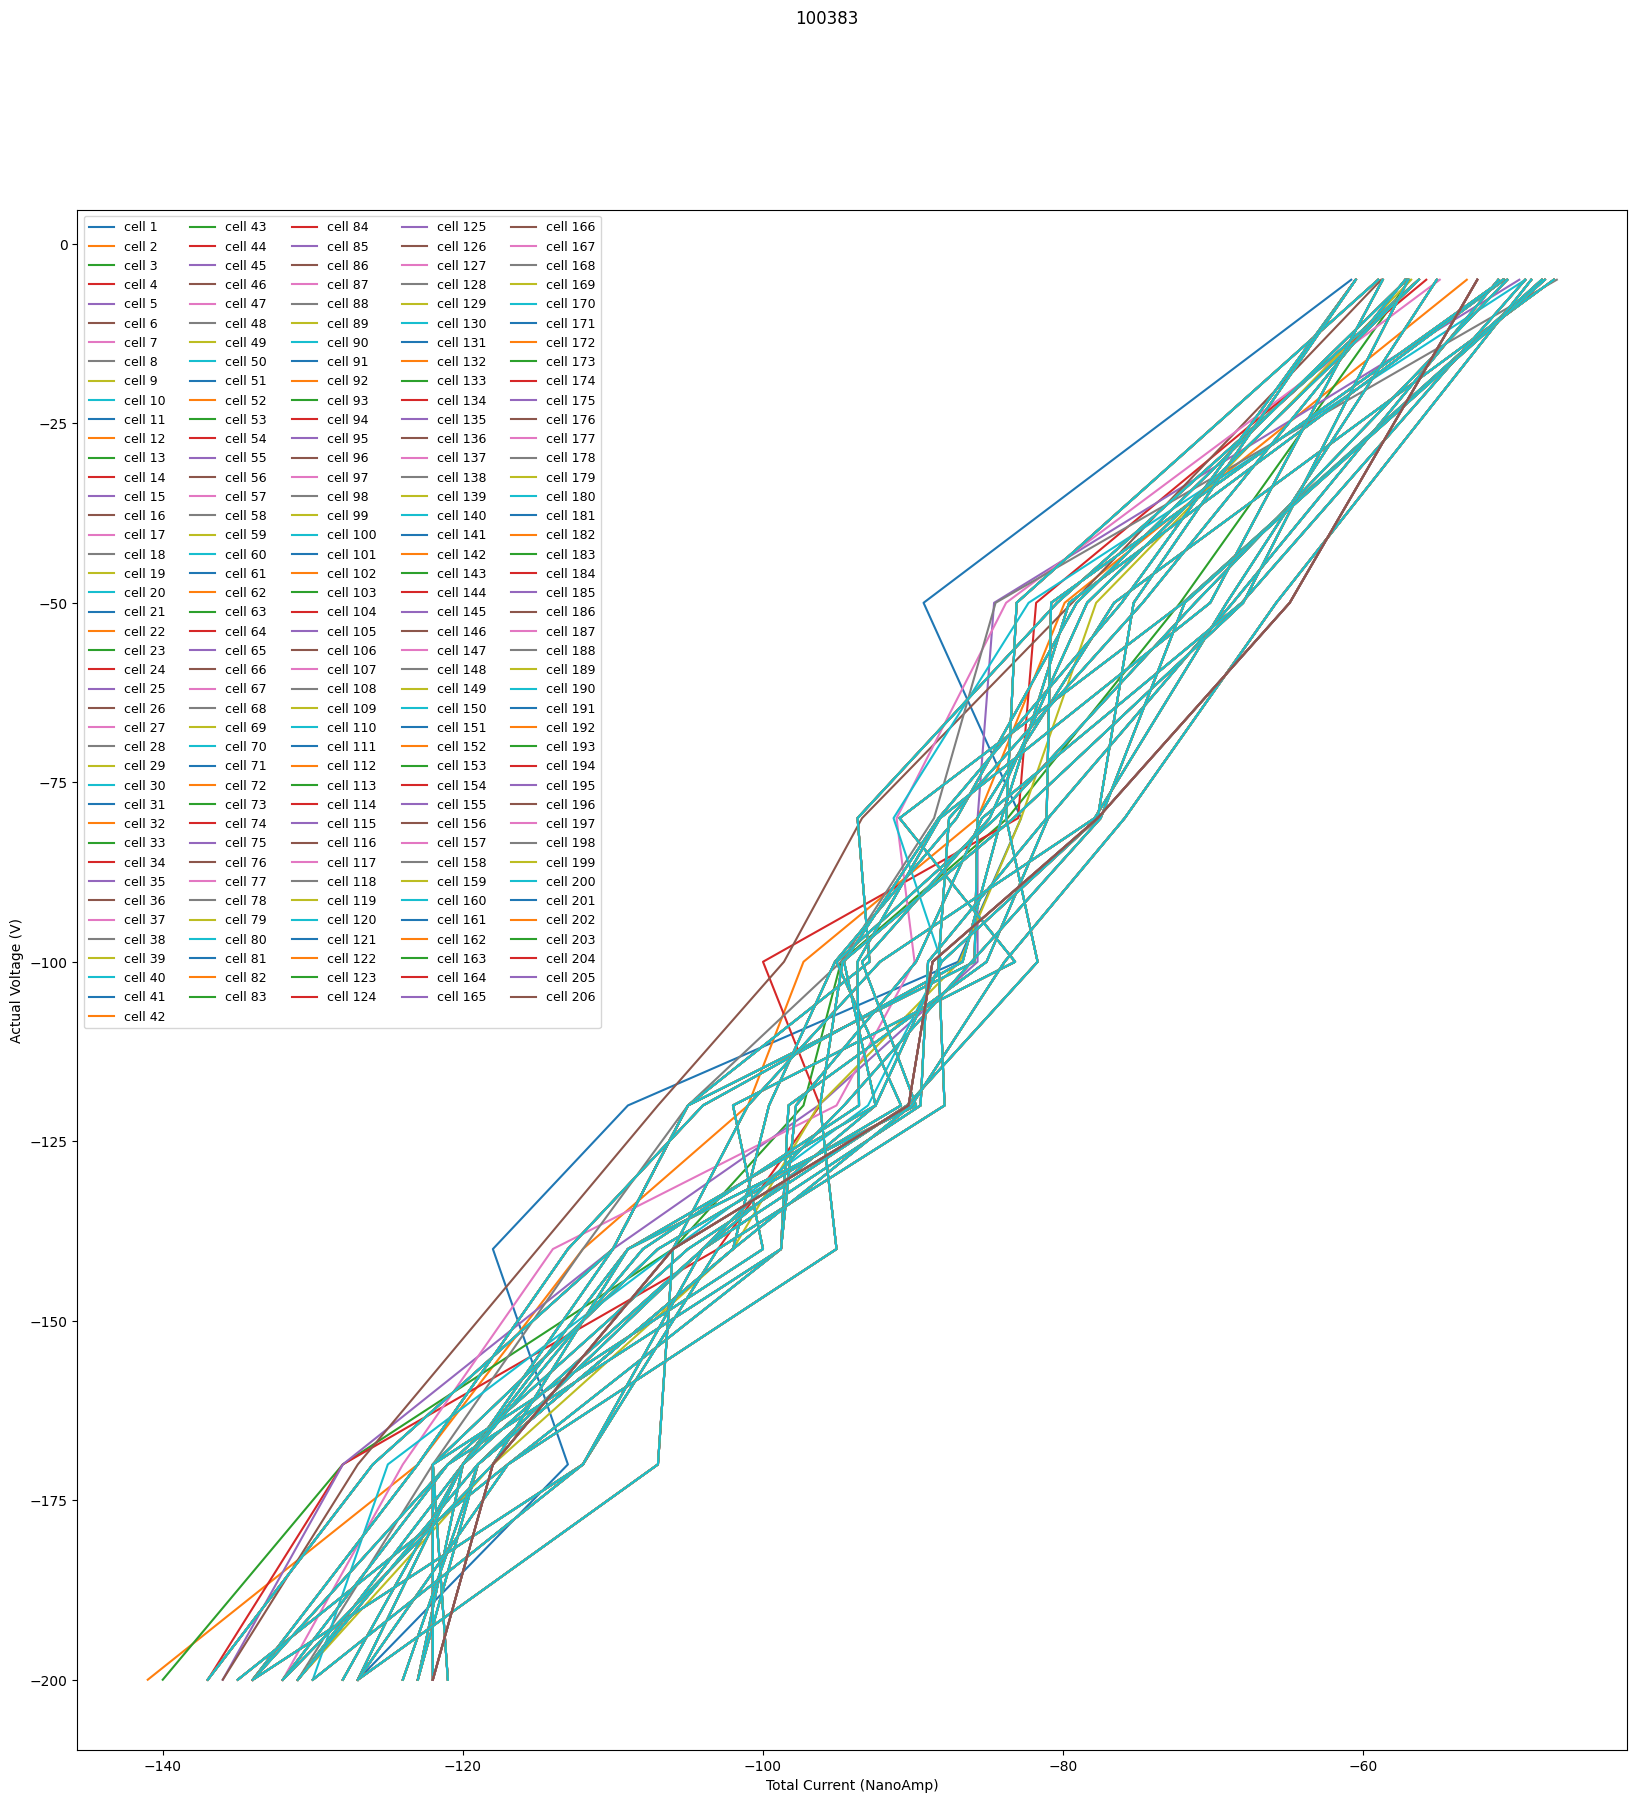

In [26]:
max_cells=IV_DF_100383['CELL_NR'].max()
serial_number='100383'#aka SCRATCHPAD_ID
fig,ax=plt.subplots(figsize=(20,20))
for cell_nr in range(1,max_cells):
    plt.plot(IV_DF_100383['TOT_CURNT_NANOAMP'][IV_DF_100383['CELL_NR']==cell_nr], IV_DF_100383['ACTUAL_VOLTS'][IV_DF_100383['CELL_NR']==cell_nr], label = f'cell {cell_nr}')
    plt.ylabel('Actual Voltage (V)'); plt.xlabel('Total Current (NanoAmp)')
    plt.legend(ncol=5, fontsize=9)
fig.suptitle(serial_number)

- Query CV table by scratchpad by me influenced from the Umesh one above. This shows all the columns that we uplokaded data for in our XML template, for the sensor with  serial number (scratchpad ID) `100383`:
```
SELECT SNSRPRT.SERIAL_NUMBER SCRATCHPAD_ID, 
SNSRPRT.NAME_LABEL SENSOR_ID,
SNSRCEL.SERIAL_NUMBER SCRATCHPAD_ID_CELL, 
HGCSNSRCV.VOLTS, 
HGCSNSRCV.CPCTNCE_PFRD,  
HGCSNSRCV.ERR_CPCTNC_PFRD, 
HGCSNSRCV.TOT_CURNT_NANOAMP, 
HGCSNSRCV.ACTUAL_VOLTS, 
HGCSNSRCV.ORG_CPCTNC_PFRD, 
HGCSNSRCV.TEMP_DEGC, 
HGCSNSRCV.HUMIDITY_PRCNT, 
HGCSNSRCV.IMP_OHM, 
HGCSNSRCV.PHS_RAD, 
HGCSNSRCV.TIME_SECS, 
HGCSNSRCV.CELL_NR  
FROM CMS_HGC_CORE_CONSTRUCT.KINDS_OF_PARTS SNSRKOP
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PARTS SNSRPRT
ON SNSRKOP.KIND_OF_PART_ID = SNSRPRT.KIND_OF_PART_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PHYSICAL_PARTS_TREE SNSRPHPRT
ON SNSRPRT.PART_ID = SNSRPHPRT.PART_PARENT_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.PARTS SNSRCEL
ON SNSRPHPRT.PART_ID = SNSRCEL.PART_ID
INNER JOIN CMS_HGC_CORE_CONSTRUCT.KINDS_OF_PARTS CELLKOP
ON SNSRCEL.KIND_OF_PART_ID = CELLKOP.KIND_OF_PART_ID
INNER JOIN CMS_HGC_CORE_COND.COND_DATA_SETS CONDS
ON SNSRCEL.PART_ID = CONDS.PART_ID
INNER JOIN CMS_HGC_CORE_COND.KINDS_OF_CONDITIONS SNSRCVKOC
ON CONDS.KIND_OF_CONDITION_ID = SNSRCVKOC.KIND_OF_CONDITION_ID
INNER JOIN CMS_HGC_HGCAL_COND.HGC_CERN_SENSOR_CV HGCSNSRCV
ON CONDS.CONDITION_DATA_SET_ID = HGCSNSRCV.CONDITION_DATA_SET_ID

WHERE CONDS.IS_RECORD_DELETED = 'F'
AND SNSRCVKOC.NAME = 'HGC CERN Sensor CV'
AND SNSRCVKOC.IS_RECORD_DELETED = 'F'
AND SNSRPRT.SERIAL_NUMBER = '100383'
ORDER BY CELL_NR, VOLTS;
```

- See the names of all the tables in the `CMS_HGC_HGCAL_COND` account (and the number of rows in each)  
```
select table_name, num_rows
from all_tables
  where owner='CMS_HGC_HGCAL_COND';
  ```
  
- see everything in the `hcg_cern_sensor_ivl` table:
```
select * from CMS_HGC_HGCAL_COND.hgc_cern_sensor_iv;
```
- See the uploaded registered parts (wafers), ordered by the time they were uploaded to the database:
```
select * from CMS_HGC_CORE_CONSTRUCT.PARTS order by RECORD_INSERTION_TIME ASC;
```

- See the registered wafer that has serial number "100113":
```
select * from CMS_HGC_CORE_CONSTRUCT.PARTS where SERIAL_NUMBER='100113'; 
```
- See the uploaded wafer kind of part ID that was uploaded by the user "`Alex%`" (i.e. it matches any user name that starts with "Alex").
```
select  KIND_OF_PART_ID, NAME_LABEL
from CMS_HGC_CORE_CONSTRUCT.PARTS Where RECORD_INSERTION_USER LIKE 'Alex%';
```

For the HGCAL data we sometimes need to use some `Inner join` commands in our SQL query. Basically `inner join` lets you join your initial table with another table, at a particular field that is the same in both tables.

- stupid way to see the first CV table that I uploaded.
```
select * from CMS_HGC_HGCAL_COND.HGC_CERN_SENSOR_CV
INNER JOIN CMS_HGC_CORE_COND.COND_DATA_SETS
ON CMS_HGC_HGCAL_COND.HGC_CERN_SENSOR_CV.CONDITION_DATA_SET_ID = CMS_HGC_CORE_COND.COND_DATA_SETS.CONDITION_DATA_SET_ID
where CMS_HGC_CORE_COND.COND_DATA_SETS.RECORD_INSERTION_USER LIKE '%Ali%'
ORDER BY CELL_NR;
```

---------
-----
# Recall the IV and CV Test Full Templates

### XML Template for Table:	HGC_CERN_SENSOR_CV

```xml
<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<ROOT xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
<HEADER>
	<TYPE>
		<EXTENSION_TABLE_NAME>HGC_CERN_SENSOR_CV</EXTENSION_TABLE_NAME>
		<NAME>HGC CERN Sensor CV Test</NAME>
	</TYPE>
	<RUN>
		<RUN_NAME>CERN HPK_8in_271_4003 CV Test</RUN_NAME>
		<RUN_BEGIN_TIMESTAMP>2018-05-14 00:00:00</RUN_BEGIN_TIMESTAMP>
		<RUN_END_TIMESTAMP>2018-05-14 00:00:00</RUN_END_TIMESTAMP>
		<INITIATED_BY_USER>Florian Pitters</INITIATED_BY_USER>
		<LOCATION>CERN</LOCATION>
		<COMMENT_DESCRIPTION>CV Test at CERN</COMMENT_DESCRIPTION>
	</RUN>
</HEADER>
<DATA_SET>
		<PART>
			<KIND_OF_PART>HPK Eight Inch 271 Sensor Cell</KIND_OF_PART>
			<SERIAL_NUMBER>HPK_8in_271_4003-010</SERIAL_NUMBER>
		</PART>

		<DATA>
			<VOLTS>25</VOLTS>
			<CPCTNCE_PFRD>103.752</CPCTNCE_PFRD>
			<ERR_CPCTNC_PFRD>0.00333346</ERR_CPCTNC_PFRD>
			<TOT_CURNT_NANOAMP>-1980</TOT_CURNT_NANOAMP>
			<ACTUAL_VOLTS>-25</ACTUAL_VOLTS>
			<ORG_CPCTNC_PFRD>207.857</ORG_CPCTNC_PFRD>
			<TEMP_DEGC>23.5</TEMP_DEGC>
			<HUMIDITY_PRCNT>44.7</HUMIDITY_PRCNT>
			<IMP_OHM>207.857</IMP_OHM>
			<PHS_RAD>23.5</PHS_RAD>
			<TIME_SEC>44.7</TIME_SEC>
			<CELL_NR>40</CELL_NR>
		</DATA>
			/*	.	*/
			/*	.	*/
			/*	.	*/
		<DATA>
			<VOLTS>25</VOLTS>
			<CPCTNCE_PFRD>103.752</CPCTNCE_PFRD>
			<ERR_CPCTNC_PFRD>0.00333346</ERR_CPCTNC_PFRD>
			<TOT_CURNT_NANOAMP>-1980</TOT_CURNT_NANOAMP>
			<ACTUAL_VOLTS>-25</ACTUAL_VOLTS>
			<ORG_CPCTNC_PFRD>207.857</ORG_CPCTNC_PFRD>
			<TEMP_DEGC>23.5</TEMP_DEGC>
			<HUMIDITY_PRCNT>44.7</HUMIDITY_PRCNT>
			<IMP_OHM>207.857</IMP_OHM>
			<PHS_RAD>23.5</PHS_RAD>
			<TIME_SEC>44.7</TIME_SEC>
			<CELL_NR>40</CELL_NR>
		</DATA>
</DATA_SET>ERR_CURNT_NANOAMP
</ROOT>
```


### XML Template for Table:	HGC_CERN_SENSOR_IV
Kind of condition: HGC CERN Sensor IV	 Test

```xml
<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<ROOT xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
<HEADER>
	<TYPE>
		<EXTENSION_TABLE_NAME>HGC_CERN_SENSOR_IV</EXTENSION_TABLE_NAME>
		<NAME>HGC CERN Sensor IV Test</NAME>
	</TYPE>

	<RUN>
		<RUN_NAME>Your Run Name</RUN_NAME>
<!-- Enter your timestamp -->
		<RUN_BEGIN_TIMESTAMP>2018-05-14 00:00:00</RUN_BEGIN_TIMESTAMP>
		<RUN_END_TIMESTAMP>2018-05-14 00:00:00</RUN_END_TIMESTAMP>
		<INITIATED_BY_USER>Your Name</INITIATED_BY_USER>
		<LOCATION>CERN</LOCATION>
		<COMMENT_DESCRIPTION>Your Comments</COMMENT_DESCRIPTION>
	</RUN>
</HEADER>
<DATA_SET>
		<PART>
			<KIND_OF_PART>120um Si Sensor HD Full</KIND_OF_PART>
			<SERIAL_NUMBER>XXXXXXXXXXXXXXXXXXX</SERIAL_NUMBER>
		</PART>

		<DATA>
<VOLTS>-25</VOLTS>
<CURNT_NANOAMP>7.609905</CURNT_NANOAMP>
<ERR_CURNT_NANOAMP>0.01653122</ERR_CURNT_NANOAMP>
<TOT_CURNT_NANOAMP>-2000</TOT_CURNT_NANOAMP>
<ACTUAL_VOLTS>-25</ACTUAL_VOLTS>
<TIME_SECS>7.609905</TIME_SECS>
<TEMP_DEGC>23</TEMP_DEGC>
<HUMIDITY_PRCNT>7.609905</HUMIDITY_PRCNT>
<CELL_NR>YYYY</CELL_NR>
		</DATA>
				.
				.
				.
		<DATA>
<VOLTS>-225</VOLTS>
<CURNT_NANOAMP>7.609905</CURNT_NANOAMP>
<ERR_CURNT_NANOAMP>0.01653122</ERR_CURNT_NANOAMP>
<TOT_CURNT_NANOAMP>-2000</TOT_CURNT_NANOAMP>
<ACTUAL_VOLTS>-25</ACTUAL_VOLTS>
<TIME_SECS>7.609905</TIME_SECS>
<TEMP_DEGC>23</TEMP_DEGC>
<HUMIDITY_PRCNT>7.609905</HUMIDITY_PRCNT>
<CELL_NR>YYYY</CELL_NR>
		</DATA>
</DATA_SET>

</ROOT>
```